In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

import torch.nn.init as init
import torch
from torch import nn
from torch.utils.data import DataLoader

In [2]:



class AminoAcidDataset(torch.utils.data.Dataset):
    '''AminoAcidDataset class
    
    This class loads the amino acid dataset from a PDB file and stores the coordinates and elements of each atom in the structure.

    Args:
        pdb_file (str): The path to the PDB file.
        padding (bool): If True, the coordinates and elements will be padded to have the same length for all residues.
    '''

    def __init__(self, pdb_file: str, padding: bool = False) -> None:
        self._amino_acids = [
            'ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 
            'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 
            'TYR', 'VAL'
        ]
        self._elements = ['C', 'N', 'O', 'S']

        self.coordinates = []
        self.elements = []
        self.residue = []
        self.input_shape = None

        with open(pdb_file, 'r') as f:
            residue_cords = []
            residue_elements = []
            residue_name = []

            for line in f:
                if line.startswith('ATOM'):
                    residue_cords.append([
                        float(line[30:38]),
                        float(line[38:46]),
                        float(line[46:54])
                    ])
                    residue_elements.append(self.one_hot_elements(line[13:14].strip()))
                    residue_name.append(self.one_hot_residues(line[17:20].strip()))
                elif line.startswith('END'):
                    self.coordinates.append(torch.tensor(residue_cords))
                    self.elements.append(torch.stack(residue_elements))
                    self.residue.append(residue_name[0])
                    residue_cords, residue_elements, residue_name = [], [], []
        
        if padding:
            self.coordinates = nn.utils.rnn.pad_sequence(self.coordinates, batch_first=True,padding_value=14)
            self.elements = nn.utils.rnn.pad_sequence(self.elements, batch_first=True, padding_value=4)
            self.input_shape = self._get_input_shape()
    
    def one_hot_residues(self, residue: str) -> torch.Tensor:
        one_hot = torch.zeros(len(self._amino_acids))
        one_hot[self._amino_acids.index(residue)] = 1
        return one_hot

    def one_hot_elements(self, element: str) -> torch.Tensor:
        one_hot = torch.zeros(len(self._elements))
        one_hot[self._elements.index(element)] = 1
        return one_hot
    
    def one_hot_residues_reverse(self, residue: torch.Tensor) -> str:
        return self._amino_acids[residue.argmax().item()]
    
    def one_hot_elements_reverse(self, element: torch.Tensor) -> str:
        return self._elements[element.argmax().item()]
    
    def _get_input_shape(self) -> tuple:
        return self.coordinates.shape[1], len(self._elements)
    
    def __getitem__(self, idx: int) -> tuple:
        return self.coordinates[idx], self.elements[idx], self.residue[idx]
    
    def __len__(self) -> int:
        return len(self.coordinates)

In [3]:


class AminoAcidCNN(nn.Module):
    """
    Convolutional Neural Network for classifying amino acids.
    """

    def __init__(self, input_channels: int, input_height: int, input_width: int) -> None:
        """
        Initialize the AminoAcidCNN model.

        Args:
            input_channels (int): Number of input channels.
            input_height (int): Height of the input images.
            input_width (int): Width of the input images.
        """
        super(AminoAcidCNN, self).__init__()
 
        # Add the first convolutional layer
        self.conv1 = nn.Conv2d(
            in_channels=input_channels, out_channels=16, kernel_size=(3, 3), padding=1
        )
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=1)  # Adjust stride to 1
        
        # Calculate the output size after the first conv and pool layer
        self.output_height = (input_height - 3 + 2 * 1) // 1 + 1  # (H - F + 2P)/S + 1
        self.output_width = (input_width - 3 + 2 * 1) // 1 + 1  # (W - F + 2P)/S + 1
        self.output_height = self.output_height // 1  # Max pooling with stride 1
        self.output_width = self.output_width // 1  # Max pooling with stride 1
        
        # Add the second convolutional layer
        self.conv2 = nn.Conv2d(
            in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1
        )
        
        # Calculate the output size after the second conv and pool layer
        self.output_height = (self.output_height - 3 + 2 * 1) // 1 + 1  # (H - F + 2P)/S + 1
        self.output_width = (self.output_width - 3 + 2 * 1) // 1 + 1  # (W - F + 2P)/S + 1
        self.output_height = self.output_height // 1  # Max pooling with stride 1
        self.output_width = self.output_width // 1  # Max pooling with stride 1
        
        # Ensure the output dimensions are valid
        assert self.output_height > 0 and self.output_width > 0, "Output dimensions are too small after conv and pool layers"
        
        # Define the fully connected layers
        self.fc1 = nn.Linear(1344, 512)
        self.bn1 = nn.BatchNorm1d(512)  # BatchNorm layer normalizes the output of the previous layer and speeds up training
        self.fc2 = nn.Linear(512, 20)  # Hidden layer
        self.softmax = nn.Softmax(dim=1)  # Softmax layer for probability distribution

        # Initialize the weights with Kaiming initialization
        init.kaiming_uniform_(self.conv1.weight)
        init.kaiming_uniform_(self.conv2.weight)
        init.kaiming_uniform_(self.fc1.weight)
        init.kaiming_uniform_(self.fc2.weight)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after passing through the network.
        """
        x = torch.relu(self.conv1(x))
        #x = self.pool(x)
        #print(f"Shape after first conv and pool: {x.shape}")
        x = torch.relu(self.conv2(x))
        #x = self.pool(x)
        #print(f"Shape after second conv and pool: {x.shape}")
        x = x.view(x.size(0), -1) 
        #print(f"Shape after flattening: {x.shape}")
        x = torch.relu(self.fc1(x))
        x = self.bn1(x)
        x = torch.relu(self.fc2(x))
        x = self.softmax(x)
        return x

In [4]:
import torch
import torch.nn as nn
import torch.nn.init as init

class AminoAcidCNN(nn.Module):
    """
    Convolutional Neural Network for classifying amino acids.
    """

    def __init__(self, input_channels: int, input_height: int, input_width: int) -> None:
        """
        Initialize the AminoAcidCNN model.

        Args:
            input_channels (int): Number of input channels.
            input_height (int): Height of the input images.
            input_width (int): Width of the input images.
        """
        super(AminoAcidCNN, self).__init__()

        # Add the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=16, kernel_size=(2, 2), padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=1)
        
        # Add the second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(2, 2), padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        
        # Calculate the output size after the conv and pool layers
        self.output_height = input_height +1  # No pooling layers
        self.output_width = input_width +1  # No pooling layers
        
        # Ensure the output dimensions are valid
        assert self.output_height > 0 and self.output_width > 0, "Output dimensions are too small after conv and pool layers"
        
        # Define the fully connected layers
        self.fc1 = nn.Linear(32 * self.output_height * self.output_width, 128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 20)
        self.softmax = nn.Softmax(dim=1)

        # Initialize the weights with Kaiming initialization
        init.kaiming_uniform_(self.conv1.weight)
        init.kaiming_uniform_(self.conv2.weight)
        init.kaiming_uniform_(self.fc1.weight)
        init.kaiming_uniform_(self.fc2.weight)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after passing through the network.
        """
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = torch.relu(self.bn2(self.conv2(x)))
        #print(f"Shape after conv layers: {x.shape}")  # Print the shape

        x = x.view(x.size(0), -1)
        x = torch.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.softmax(x)
        return x

In [20]:
dataset = AminoAcidDataset('data/amino_acids_high_res_augmented.pdb', padding=True)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


In [21]:

train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=True)

In [22]:

from torch import optim

N, M = dataset.input_shape
print(N, M)
model = AminoAcidCNN(input_channels=1, # Since we added an extra dimension for batch and channel
                     input_height=N, # Number of atoms
                     input_width=3) # 3 coordinates
criterium = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

20 4


In [23]:
# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=True)

In [27]:
n_epochs = 30
total_loss = []
epoch_lr = []
model.train()  # Set the model to training mode
optimizer = optim.Adam(model.parameters(), lr=0.0001)
data_loader = train_dataloader
criterion = criterium
for epoch in range(n_epochs):
    t_start = time.time()
    epoch_loss = 0.0
    for coordinates, _, residue in data_loader:
        # Combine coordinates and elements into a single tensor
        input_data = coordinates
        
        input_data = input_data.unsqueeze(1)
        #print(input_data.shape)
        
        # Forward pass
        output = model(input_data)

        # Calculate the loss
        target = torch.argmax(residue, dim=1)
        loss = criterion(output, target)

        # Backward pass and optimization
        optimizer.zero_grad()  # Clear the gradients
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model parameters

        # Accumulate the loss
        epoch_loss += loss.item()

    # Calculate the average loss for the epoch
    epoch_loss /= len(data_loader)
    total_loss.append(epoch_loss)
    epoch_lr.append(optimizer.param_groups[0]['lr'])

    # If the loss is not decreasing in the last 5 epochs, reduce the learning rate
    if len(total_loss) > 5 and all(total_loss[-1] >= total_loss[-i-1] for i in range(1, 6)):
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.5
            print(f'Reducing learning rate to {param_group["lr"]}')

    # If the loss is not decreasing in the last 10 epochs, stop training
    if len(total_loss) > 10 and all(total_loss[-1] >= total_loss[-i-1] for i in range(1, 11)):
        print('Stopping training')
        break

    print(f'Epoch {epoch + 1}/{n_epochs}, Loss: {epoch_loss:.5f} (in {time.time() - t_start:.0f}s)', end='\r')
training_dict = { 'model': model, 'optimizer': optimizer, 'total_loss': total_loss, 'learning_rate': epoch_lr }

Reducing learning rate to 5e-055s)


In [11]:
# save the model

torch.save(model, 'models/model_deep.pth')

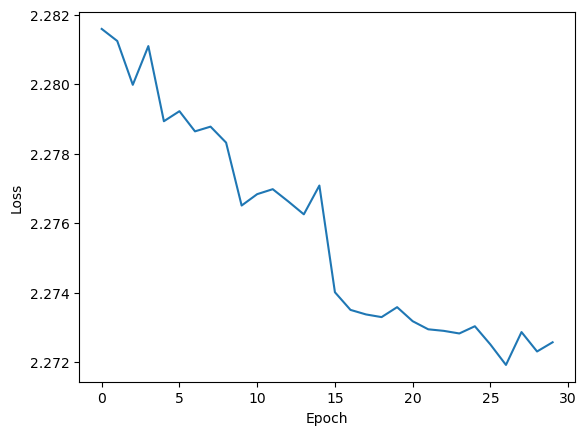

In [28]:
# plot the loss

import matplotlib.pyplot as plt

plt.plot(total_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

In [144]:
model.eval()  # Set the model to evaluation mode
from torchmetrics import Accuracy
accuracy =  Accuracy(task='MULTICLASS', num_classes=20)  # Adjust num_classes as needed
accuracy.reset() # Reset the running accuracy
data_loader = test_dataloader
with torch.no_grad():
    for coordinates, _, residue in data_loader:
        # Combine coordinates and elements into a single tensor
        input_data = coordinates
        input_data = input_data.unsqueeze(1)

        # Forward pass
        output = model(input_data)

        # Calculate the accuracy
        target = torch.argmax(residue, dim=1)
        accuracy.update(output, target)

print({"accuracy": accuracy.compute().item()})

{'accuracy': 0.7213848233222961}


{'precision': 0.7206339240074158, 'recall': 0.7381584048271179}


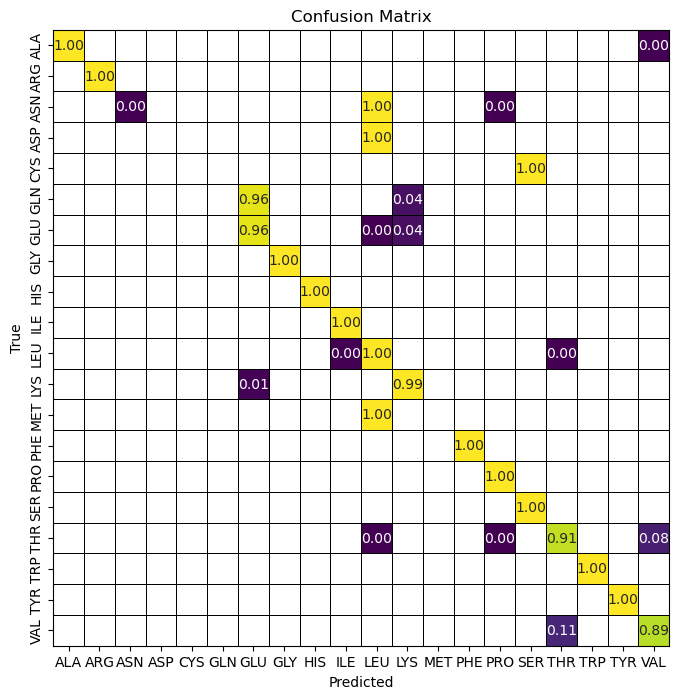

In [29]:
# get the per amino acid precision and recall
from torchmetrics import Precision, Recall

precision = Precision(num_classes=20, average='macro', task='MULTICLASS')
recall = Recall(num_classes=20, average='macro', task='MULTICLASS')
precision.reset()
recall.reset()

data_loader = test_dataloader
for coordinates, _, residue in data_loader:
    # Combine coordinates and elements into a single tensor
    input_data = coordinates
    input_data = input_data.unsqueeze(1)

    # Forward pass
    output = model(input_data)

    # Calculate the precision and recall
    target = torch.argmax(residue, dim=1)
    precision.update(output, target)
    recall.update(output, target)

print({"precision": precision.compute().item(), "recall": recall.compute().item()})

amino_acids = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU',
                'GLY', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 
                'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL']

# get the confusion matrix  
from torchmetrics import ConfusionMatrix

confusion_matrix = ConfusionMatrix(num_classes=20, task='MULTICLASS')
confusion_matrix.reset()

data_loader = test_dataloader
for coordinates, _, residue in data_loader:
    # Combine coordinates and elements into a single tensor
    input_data = coordinates
    input_data = input_data.unsqueeze(1)

    # Forward pass
    output = model(input_data)

    # Calculate the confusion matrix
    target = torch.argmax(residue, dim=1)
    confusion_matrix.update(output, target)


# plot the confusion matrix with the amino acids as labels


# Assuming confusion_matrix and amino_acids are already defined
confusion_matrix = confusion_matrix.compute().numpy()
confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)
plt.figure(figsize=(8, 8))

# Only show any values > 0
confusion_matrix = np.where(confusion_matrix > 0, confusion_matrix, np.nan)

# Show a grid line in between each cell
ax = sns.heatmap(confusion_matrix, square=True, annot=True, xticklabels=amino_acids, yticklabels=amino_acids, cmap='viridis', fmt='.2f', cbar=False, linewidths=0.5, linecolor='black')

for _, spine in ax.spines.items():
    spine.set_visible(True)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

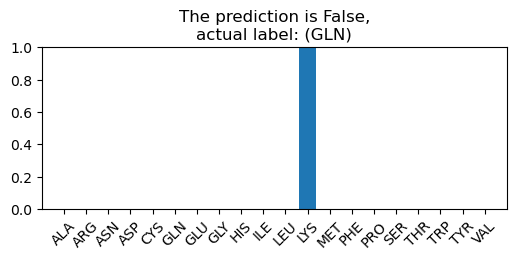

In [ ]:
amino_acids = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU',
                'GLY', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 
                'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL']
coordinates, elements, residue = dataset[int(torch.randint(0, len(dataset), (1,)))]
input_data = coordinates
input_data = input_data.unsqueeze(0).unsqueeze(0)

model.eval()
output = model(input_data)

# Plot the predicted distribution as a bar chart
fig, ax = plt.subplots(figsize=(6,2.1))
ax.bar(range(20), output.detach().numpy().squeeze())
ax.set_xticks(range(20))
ax.set_xticklabels(amino_acids, rotation=45)
correct_prediction = (torch.argmax(output) == torch.argmax(residue))

# Set the title with prediction result
ax.set_title(f'The prediction is {correct_prediction},\n'
                f'actual label: ({amino_acids[int(torch.argmax(residue))]})')

ax.set_ylim(0, 1)
ax.set_xlim(-1, 20)

plt.show()

In [ ]:
amino_acids = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU',
                'GLY', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 
                'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL']

resid_dict = dataset._amino_acids
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
correct_asn = 0
false_asn = 0
for coordinates, elements, residue in dataloader:
    input_data = coordinates
    input_data = input_data.unsqueeze(1)
    output = model(input_data)
    target = torch.argmax(residue, dim=1)
    if target == 2:
        if torch.argmax(output) == 2:
            correct_asn += 1
        else:
            false_asn += 1

    #for i in range(len(target)):
    #    if torch.argmax(output[i]) != target[i]:
    #        print(f'Actual label: {resid_dict[int(target[i])]}, predicted label: {resid_dict[int(torch.argmax(output[i]))]}')
    #        print(f'Actual label: {target[i]}, predicted label: {torch.argmax(output[i])}')
    #        # plot the output
    #        #plt.figure(figsize=(6, 2.4))
    #        #plt.bar(range(20),output[i].detach().numpy())
    #        #plt.xlim(0, 20)
    #        #plt.xticks(range(20), amino_acids, rotation=45)
    #        #plt.ylim(0, 1)
    #        #plt.show()
    #        print('')

print(f'Correct ASN: {correct_asn}, False ASN: {false_asn}')


Correct ASN: 0, False ASN: 3075
